In [1]:
import awkward as ak
import numpy as np
import hist as hs
from coffea import processor, hist as chs
from coffea.nanoevents.methods import vector, candidate
from numba import jit

from coffea.nanoevents import BaseSchema
import mplhep as hep
import matplotlib.pyplot as plt
from datetime import date
today = date.today()

plt.style.use(hep.style.CMS)

/uscms_data/d3/aaportel/mambaforge/envs/analysis-env/lib/python3.9/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [2]:
class LLP_ntuple_processor(processor.ProcessorABC):
    """
    This class is used to process the ntuples created by the LLP ntuple producer.
    """
    
    def zipper(self, events: ak.Array, prepends: list[str]) -> dict:
        return {prepend:
            ak.zip(
            {field[len(prepend):].lower(): events[field] for field in events.fields if field.startswith(prepend)},
            with_name='PtEtaPhiMLorentzVector',
            behavior=vector.behavior,
            )
            for prepend in prepends
        }

    
    def cscClusterCutter(self, events, cut): #in place    
        newEvents = {}
        for prepend in events:
            if '[nCscRechitClusters]' in str(events[prepend].layout): 
                newEvents[prepend] = events[prepend].mask[cut] #cuts on the cluster level
                newEvents[prepend] = newEvents[prepend].mask[ak.any(cut, axis=1)]
            else:
                newEvents[prepend] = events[prepend].mask[ak.any(cut, axis=1)] #cuts on the event level if there are no such clusters left in event
            
            newEvents[prepend] = newEvents[prepend][~ak.is_none(newEvents[prepend])]
        return newEvents
                
    def simpleCutter(self, events, cut):
        newEvents = {}
        for prepend in events:
            newEvents[prepend] = events[prepend][cut]
        return newEvents
     
    def gLLP_acc_cut(self, events):
        cut = (events['gLLP_'].csc == 1)
        return self.simpleCutter(events, cut)        

    def csc_eff_cut(self, events):
        cut = (events['n'].cscrechitclusters >= 1)
        return self.simpleCutter(events, cut)  
    
    def met_cut(self, events):
        cut = (events['met'].eenoise >= 30)
        return self.simpleCutter(events, cut)
    
    def csc_muon_veto(self, events):
        cut = (events['cscRechitCluster'].muonvetopt < 20)
        return self.cscClusterCutter(events, cut)
            
    def csc_jet_veto(self, events):
        cut = (events['cscRechitCluster'].jetvetopt < 10)
        return self.cscClusterCutter(events, cut)
                                                    
    def csc_time_cut(self, events):
        cut = ((events['cscRechitCluster'].timeweighted <= 12.5)&
               (events['cscRechitCluster'].timeweighted >= -5  )) 
        return self.cscClusterCutter(events, cut)
                                                    
    def csc_ME11_veto(self, events):
        cut = ((events['cscRechitCluster'].nrechitchamberplus11  <= 0)&
               (events['cscRechitCluster'].nrechitchamberminus11 <= 0))
        return self.cscClusterCutter(events, cut)                                                  
    
    def csc_ME12_veto(self, events):
        cut = ((events['cscRechitCluster'].nrechitchamberplus12  <= 0)&
               (events['cscRechitCluster'].nrechitchamberminus12 <= 0))
        return self.cscClusterCutter(events, cut)
                                                    
    def csc_re12_veto(self, events):
        cut = (events['cscRechitCluster']._match_re12_0p4 == 0)
        return self.cscClusterCutter(events, cut)
                                                    
    def csc_mb1_veto(self, events):
        cut = (events['cscRechitCluster']._match_mb1seg_0p4 == 0)
        return self.cscClusterCutter(events, cut)
    
    def csc_rb1_veto(self, events):
        cut = (events['cscRechitCluster']._match_rb1_0p4 == 0)
        return self.cscClusterCutter(events, cut)
                                              
    def gLLP_eta_cut(self, events):
        cut = abs(events['gLLP_'].eta) < 2 
        return self.simpleCutter(events, cut) 

    def csc_timeSpread_cut(self, events):
        cut = (events['cscRechitCluster'].timespreadweightedall <= 20)
        return self.cscClusterCutter(events, cut)

    
    def csc_cut_based(self, events):
        cut = (((events['cscRechitCluster'].nstation10 >  1) & (abs(events['cscRechitCluster'].eta) < 1.9))|
               ((events['cscRechitCluster'].nstation10 == 1) & (abs(events['cscRechitCluster'].avgstation10) == 4) & (abs(events['cscRechitCluster'].eta) < 1.8))|
               ((events['cscRechitCluster'].nstation10 == 1) & (abs(events['cscRechitCluster'].avgstation10) == 3) & (abs(events['cscRechitCluster'].eta) < 1.6))|
               ((events['cscRechitCluster'].nstation10 == 1) & (abs(events['cscRechitCluster'].avgstation10) == 2) & (abs(events['cscRechitCluster'].eta) < 1.6))|
               ((events['cscRechitCluster'].nstation10 == 1) & (abs(events['cscRechitCluster'].avgstation10) == 1) & (abs(events['cscRechitCluster'].eta) < 1.1))
              )
        return self.cscClusterCutter(events, cut)
    
    def csc_dphi_cut(self, events):
        cut = (abs(events['cscRechitCluster'].meteenoise_dphi) < 0.75)
        return self.cscClusterCutter(events, cut)

    
    def csc_nrechits_cut(self, events): #~~~~~~~~~~~~~
        cut = (events['cscRechitCluster'].size > 130)
        return self.cscClusterCutter(events, cut)

                                                                                                    
    def process(self, events):

        dataset = events.metadata['dataset']
        out = {
            dataset: {
                "entries": len(events),
            }
        }
        
        prepends = ['cscRechitCluster', 'met', 'n']
        if dataset == 'signal':
            prepends.append('gLLP_')
            

        events = self.zipper(events, prepends)
        
        cutnames = [self.gLLP_acc_cut, self.csc_eff_cut, self.met_cut, self.csc_muon_veto,
                self.csc_jet_veto, self.csc_time_cut, self.csc_ME11_veto, self.csc_ME12_veto,
                self.csc_re12_veto, self.csc_mb1_veto, self.csc_rb1_veto, self.gLLP_eta_cut, 
                self.csc_timeSpread_cut, self.csc_cut_based, self.csc_dphi_cut, self.csc_nrechits_cut]
           
        last = events
        
        def histsaver(out, last, cutname):
            
            
            out[dataset][cutname] = len(last)
            
            out[dataset][f'{cutname}_met'] = hs.Hist.new.Reg(30, 0, 100, name='met', label='MET [GeV]').Double()
            out[dataset][f'{cutname}_dphi'] = hs.Hist.new.Reg(30, 0, 5, name='dPhi', label='dPhi').Double()
            out[dataset][f'{cutname}_timeSpread'] = hs.Hist.new.Reg(30, 0, 20, name='timeSpread', label='time').Double()
            out[dataset][f'{cutname}_clsTimeWeighted'] = hs.Hist.new.Reg(30, -5.5, 13, name='clsTimeWeighted', label='time').Double()
            out[dataset][f'{cutname}_clsSize'] = hs.Hist.new.Reg(30, 0, 130, name='clsSize', label='hits').Double()
            out[dataset][f'{cutname}_clsEta'] = hs.Hist.new.Reg(30, 0, 4, name='clsEta', label='eta').Double()            
            out[dataset][f'{cutname}_NStation10'] = hs.Hist.new.Reg(30, -10, 10, name='NStation10', label='NStation10').Double()            
            out[dataset][f'{cutname}_AvgStation10'] = hs.Hist.new.Reg(30, -10, 10, name='AvgStation10', label='AvgStation10').Double()
            
            out[dataset][f'{cutname}_met'].fill(ak.flatten(last['met'].eenoise, axis=None))
            out[dataset][f'{cutname}_dphi'].fill(ak.flatten(last['cscRechitCluster'].meteenoise_dphi, axis=None))
            out[dataset][f'{cutname}_timeSpread'].fill(ak.flatten(last['cscRechitCluster'].timespreadweightedall, axis=None))
            out[dataset][f'{cutname}_clsTimeWeighted'].fill(ak.flatten(last['cscRechitCluster'].timeweighted, axis=None))         
            out[dataset][f'{cutname}_clsSize'].fill(ak.flatten(last['cscRechitCluster'].size, axis=None))
            out[dataset][f'{cutname}_clsEta'].fill(ak.flatten(abs(last['cscRechitCluster'].eta), axis=None))        
            out[dataset][f'{cutname}_NStation10'].fill(ak.flatten(last['cscRechitCluster'].nstation10, axis=None))
            out[dataset][f'{cutname}_AvgStation10'].fill(ak.flatten(last['cscRechitCluster'].avgstation10, axis=None))
            
        histsaver(out, last, 'total')

        for cutname in cutnames:
            if cutname.__name__.startswith('gLLP'):
                last = last
            else:
                last = cutname(last)
            
            #last = cutname(last)
   
            histsaver(out, last, cutname.__name__)
       
        return out   
    
    def postprocess(self, accumulator):
        return accumulator


In [3]:
date = today.strftime("%m_%d_%y")

fileset = {}
fileset['signal']     = ['root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v2/v3/normalized/BToKPhi_MuonGenFilter_mPhi1p0_ctau1000_1pb_weighted.root',]
fileset['background'] = ['root://cmsxrootd.fnal.gov//store/user/christiw/displacedJetMuonAnalyzer/csc/V1p171/Data2018_UL/v3/normalized/ParkingBPH4_Run2018A_goodLumi.root']
out = processor.run_uproot_job(
    fileset,
    treename="MuonSystem",
    processor_instance=LLP_ntuple_processor(),
    executor=processor.futures_executor,
    executor_args={"schema": BaseSchema, "workers": 8},
    #maxchunks = 1
)

#cuts = ['total', 'acc_cut', 'ME11_veto', 'ME12_veto', 're12_cut', 'mb1_cut', 'rb1_cut']
cuts = ['total', 'acc_cut','csc_eff_cut', 'met_cut', 'muon_veto', 'jet_cut', 'time_cut', 'ME11_veto', 'ME12_veto', 're12_cut', 'mb1_cut', 'rb1_cut', 'eta_cut', 'time_spread_cut', 'cut_based', 'dphi_cut', 'nrechits_cut']

Output()

Output()

KeyboardInterrupt: 

In [25]:
for cut in cuts:
    h = out['signal'][cut]
    print(f'{cut}, {h}')

total, 823789
acc_cut, 83514
met_cut, 36800
csc_eff_cut, 6478
muon_veto, 6317
jet_cut, 4882
time_cut, 3903
ME11_veto, 2809
ME12_veto, 2205
re12_cut, 2177
mb1_cut, 2159
rb1_cut, 2134
eta_cut, 1358
time_spread_cut, 1324
cut_based, 867
dphi_cut, 269
nrechits_cut, 73


In [60]:
from hist.intervals import ratio_uncertainty
def ratio(num, den, ax):
    ax.errorbar(
        x=num.axes[0].centers,
        y=num.view() / den.view() ,
        yerr=ratio_uncertainty(num.view(), den.view()),
        color="k",
        linestyle="none",
        marker="o",
        elinewidth=1,
    )
    return ax


/tmp/ipykernel_29546/4019254757.py:5: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_29546/4019254757.py:5: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_29546/4019254757.py:5: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_29546/4019254757.py:5: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_29546/4019254757.py:5: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_29546/4019254757.py:5: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_29546/4019254757.py:5: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,


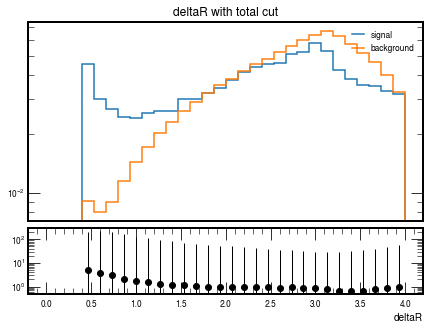

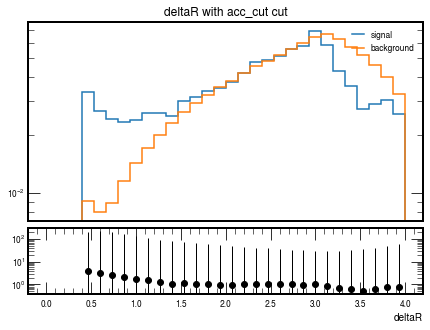

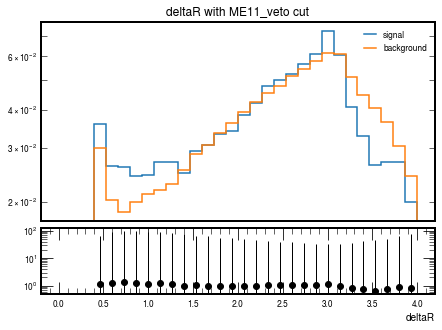

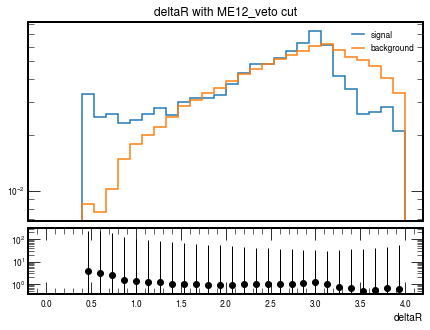

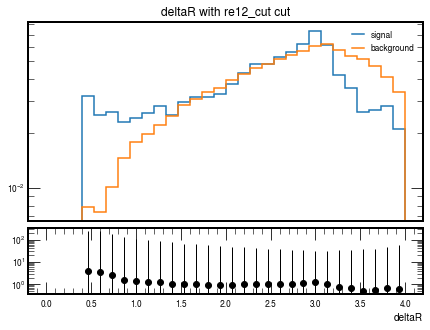

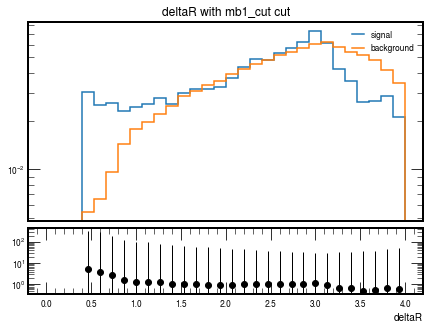

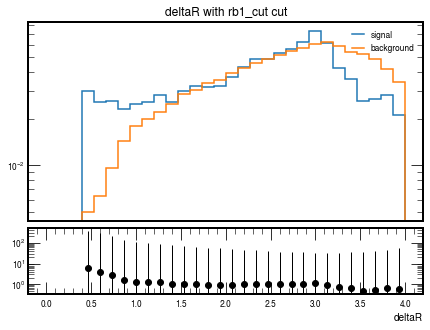

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

varname = 'deltaR'

#pdf = PdfPages(f'{varname}_cutflow_sb.pdf')

l = len(cuts)
for cut in cuts:
    fig, ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(np.sqrt(2)*5,5))
    
    signal = out['signal'][f'{cut}_{varname}_muon_cls']
    background = out['background'][f'{cut}_{varname}_muon_cls']

    hep.histplot(signal/signal.sum(), label='signal', ax=ax[0])
    hep.histplot(background/background.sum(), label='background', ax=ax[0])
    ax[0].set_title(f'{varname} with {cut} cut')
    ax[0].legend()
    ax[0].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    ax[0].set(xlabel=None)
    ax[0].set_yscale('log')
    
    ratio(signal/signal.sum(), background/background.sum(), ax[1])
    ax[1].set_xlim(ax[0].get_xlim())
    ax[1].set(xlabel=varname)
    ax[1].set_yscale('log')
    fig.subplots_adjust(wspace=0, hspace=.05)
#    pdf.savefig(fig)
#pdf.close()


In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import warnings

with warnings.catch_warnings(): #i don't need to see all the divide by zero warnings
    warnings.simplefilter("ignore")
    
    varnames = ['met', 'timeSpread', 'clsEta', 'clsTimeTotal',
                'deltaR_muon_cls', 'deltaEta_muon_cls', 'deltaPhi_muon_cls',
                'NStation10', 'AvgStation10',
                'clsEta_NStation==1', 'NStation10_NStation==1', 'AvgStation10_NStation==1',
                'clsEta_NStation>1', 'NStation10_NStation>1', 'AvgStation10_NStation>1',]

    for varname in varnames:
        pdf = PdfPages(f'varPlots_sb_clsCuts_{date}/{varname}_cutflow_sb.pdf')

        for cut in cuts:
            fig, ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(np.sqrt(2)*5,5))

            signal = out['signal'][f'{cut}_{varname}']
            background = out['background'][f'{cut}_{varname}']

            hep.histplot(signal/signal.sum(), label='signal', ax=ax[0])
            hep.histplot(background/background.sum(), label='background', ax=ax[0])
            ax[0].set_title(f'{varname} with {cut} cut')
            ax[0].legend()
            ax[0].tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
            ax[0].set(xlabel=None)
            ax[0].set_yscale('log')

            ratio(signal/signal.sum(), background/background.sum(), ax[1])
            ax[1].set_xlim(ax[0].get_xlim())
            ax[1].set(xlabel=varname)
            ax[1].set_yscale('log')
            fig.subplots_adjust(wspace=0, hspace=.05)
            pdf.savefig(fig)
        pdf.close()


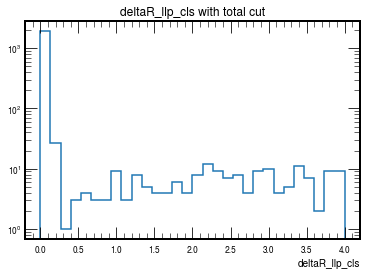

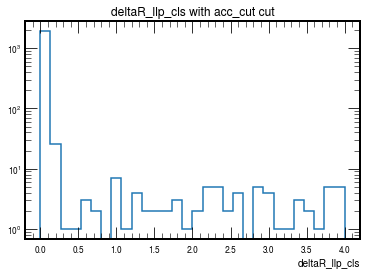

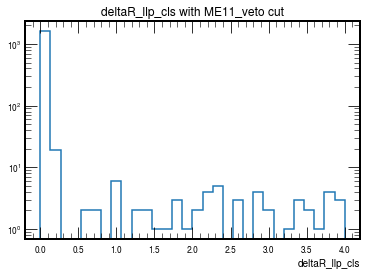

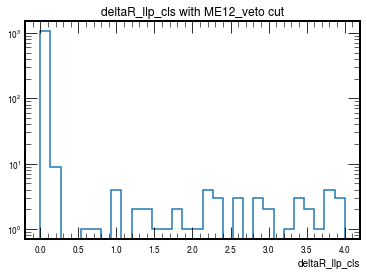

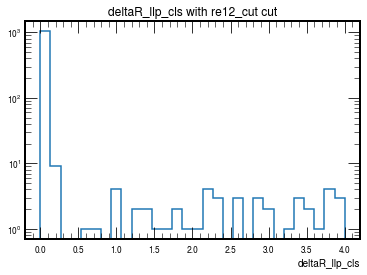

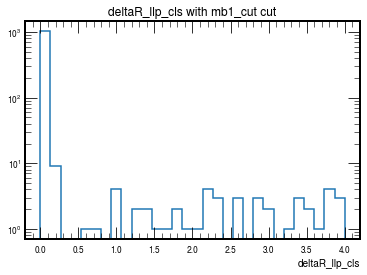

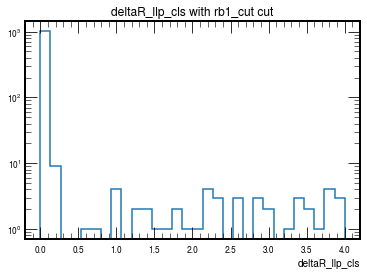

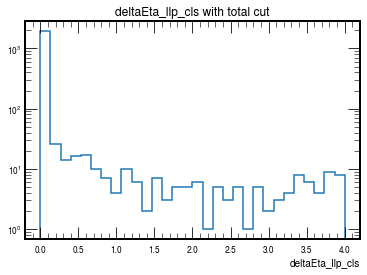

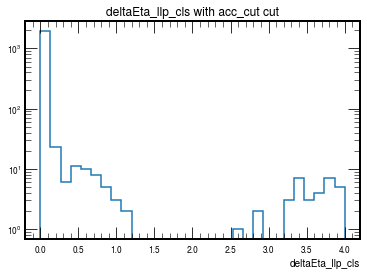

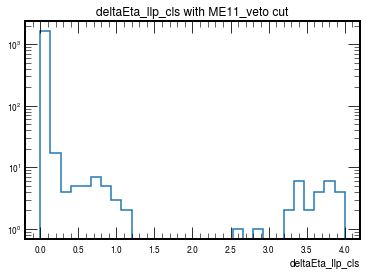

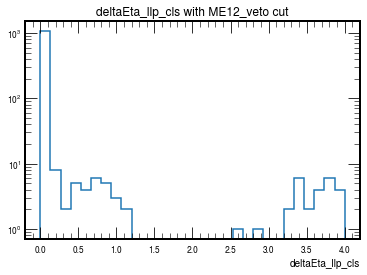

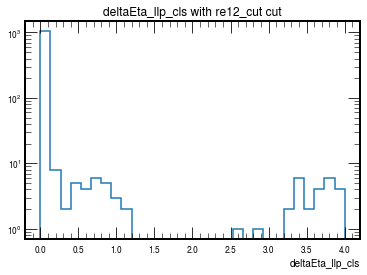

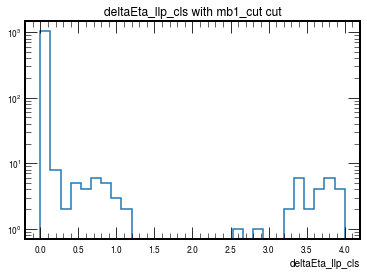

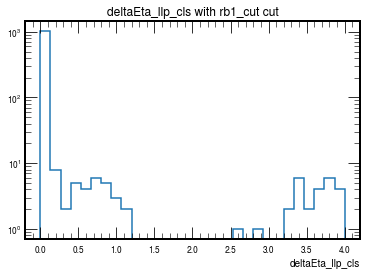

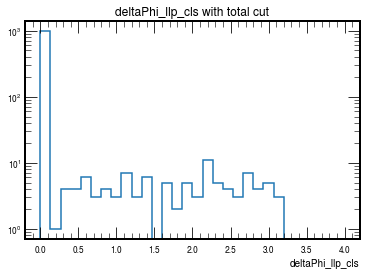

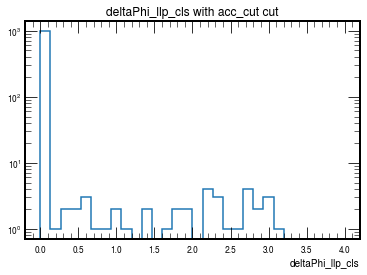

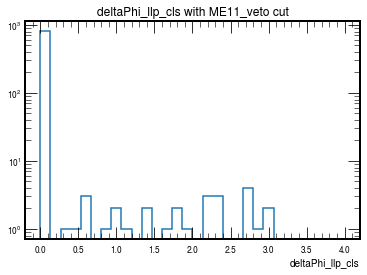

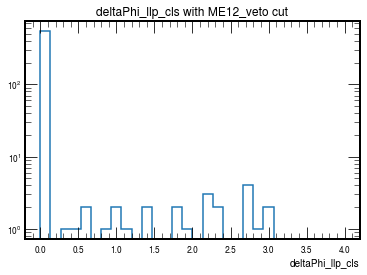

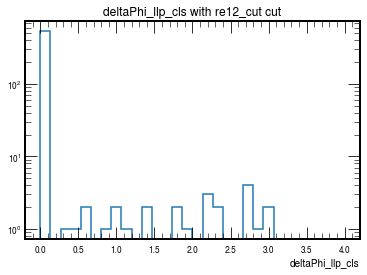

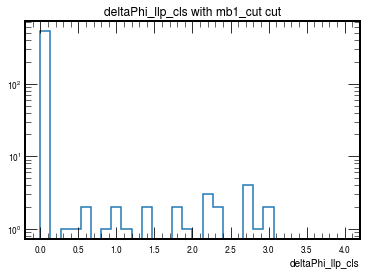

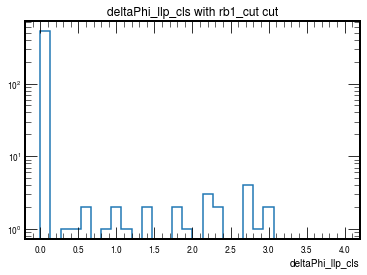

In [6]:
from matplotlib.backends.backend_pdf import PdfPages
import warnings

with warnings.catch_warnings(): #i don't need to see all the divide by zero warnings
    warnings.simplefilter("ignore")
    
    varnames = ['deltaR_llp_cls', 'deltaEta_llp_cls', 'deltaPhi_llp_cls',]

    for varname in varnames:
        pdf = PdfPages(f'deltaREtaPhi_llp_cls_ss_{date}/{varname}_cutflow_sb.pdf')

        for cut in cuts:
            fig, ax = plt.subplots()

            signal = out['signal'][f'{cut}_{varname}']

            hep.histplot(signal, label='signal', ax=ax)
            ax.set_title(f'{varname} with {cut} cut')
            ax.set_yscale('log')
            pdf.savefig(fig)
        pdf.close()


In [5]:
h = out['signal']['rb1_cut_deltaR_llp_cls']
h[1.j:].sum()/h.sum()

0.040262172284644196